In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [4]:
# Load the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Display the first few rows of each dataset
print(customers.head())
print(products.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [5]:
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())


CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


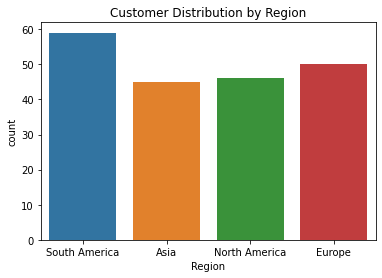

In [6]:
sns.countplot(data=customers, x='Region')
plt.title("Customer Distribution by Region")
plt.show()


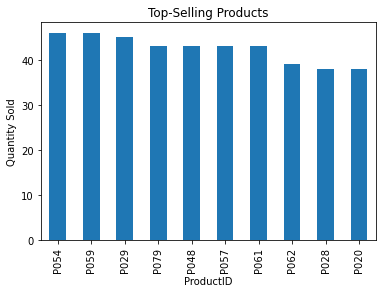

In [7]:
top_products = transactions.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='bar')
plt.title("Top-Selling Products")
plt.xlabel("ProductID")
plt.ylabel("Quantity Sold")
plt.show()


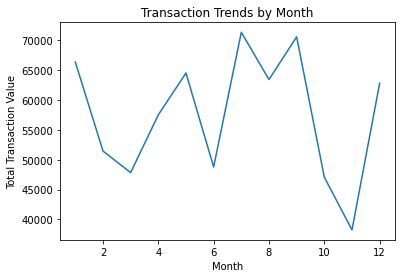

In [8]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions.groupby(transactions['TransactionDate'].dt.month).sum()['TotalValue'].plot(kind='line')
plt.title("Transaction Trends by Month")
plt.xlabel("Month")
plt.ylabel("Total Transaction Value")
plt.show()


In [10]:
# Merge datasets
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

# Create a pivot table for customer-product matrix
customer_product_matrix = merged_data.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', fill_value=0)

# Calculate cosine similarity
similarity_matrix = cosine_similarity(customer_product_matrix)

# Convert to a DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.index)


In [12]:
lookalike_results = {}
for customer in similarity_df.index[:20]:
    similar_customers = similarity_df.loc[customer].sort_values(ascending=False).iloc[1:4]
    lookalike_results[customer] = list(similar_customers.index) + list(similar_customers.values)

# Save results as CSV
lookalike_df = pd.DataFrame.from_dict(lookalike_results, orient='index', columns=['Similar_Cust_1', 'Score_1', 'Similar_Cust_2', 'Score_2', 'Similar_Cust_3', 'Score_3'])
lookalike_df.to_csv("Lookalike.csv", index_label="CustomerID")


In [13]:
# Aggregate data by CustomerID
customer_features = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).rename(columns={'TransactionID': 'TransactionCount'})

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)


In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)


In [15]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.8650620583623065


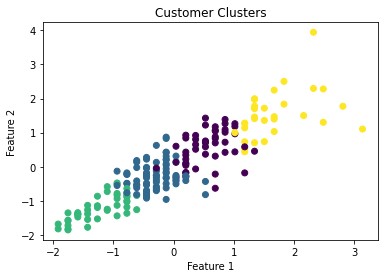

In [16]:
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=customer_features['Cluster'])
plt.title("Customer Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
